### Dataset Information

The data has 506 entries represents aggregate information about 14 features of homes from various suburbs located in Boston.
The features can be summarized as follows:
* CRIM: This is the per capita crime rate by town
* ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* INDUS: This is the proportion of non-retail business acres per town.
* CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* NOX: This is the nitric oxides concentration (parts per 10 million)
* RM: This is the average number of rooms per dwelling
* AGE: This is the proportion of owner-occupied units built prior to 1940
* DIS: This is the weighted distances to five Boston employment centers
* RAD: This is the index of accessibility to radial highways
* TAX: This is the full-value property-tax rate per 1000 bucks
* PTRATIO: This is the pupil-teacher ratio by town
* B: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* LSTAT: This is the percentage lower status of the population
* PRICE: This is the median value of owner-occupied homes in 1000s

In [1]:
!pip install keras
!pip install tensorflow

In [2]:
import pandas as pd

In [3]:
# load data and arrange into Pandas dataframe
df = pd.read_csv("housing_data_for_regression.csv", delim_whitespace=True, header=None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']


df.columns = feature_names

In [6]:
#Shape of the data
print(df.shape)

(506, 14)


### Detect outliers in the continuous columns
Outliers are observations that lie far away from majority of observations in the dataset and can be represented mathematically in different ways.

One method of defining outliers are: outliers are data points lying beyond (third quartile + 1.5xIQR) and below (first quartile - 1.5xIQR).

The function below takes a dataframe and outputs the number of outliers in every numeric feature based on the above rule of IQR


In [7]:
# Function to detect outliers in every feature
import numpy as np
def detect_outliers(df):
    cols = list(df)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in df.select_dtypes(include=np.number).columns:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df)

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\2319905281.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append({'Feature':column, 'Number of Outliers':df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]},ignore_index=True)
C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\2319905281.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append({'Feature':column, 'Number of Outliers':df.loc[(df[column] < fence_low) | (df[column] > fence_high)].shape[0]},ignore_index=True)
C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\2319905281.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outliers = outliers.append({'Feature':column, 'Number of Outliers

,Feature,Number of Outliers
0,CRIM,66
1,ZN,68
2,INDUS,0
3,CHAS,35
4,NOX,0
5,RM,30
6,AGE,0
7,DIS,5
8,RAD,0
9,TAX,0


Observations :
As per the IQR methodology, there are outliers in majority of the columns.
In the further steps below, we will see how to deal with the outliers

### Treating outliers in the continuous columns
* Outliers can be treated in a variety of ways. It depends on the skewness of the feature.
* To reduce right skewness, we use roots or logarithms or reciprocals (roots are weakest). This is the most common problem in practice.
* To reduce left skewness, we take squares or cubes or higher powers.
* But in our data, some of the features have negative values and also the value 0. In such cases, square root transform or logarithmic transformation cannot be used since we cannot take square root of negative values and logarithm of zero is not defined.
* Hence for this data we use a method called Winsorization. In this method we define a confidence interval of let's say 90% and then replace all the outliers below the 5th percentile with the value at 5th percentile and all the values above 95th percentile with the value at the 95th percentile. It is pretty useful when there are negative values and zeros in the features which cannot be treated with log transforms or square roots. 

In [8]:
from scipy.stats.mstats import winsorize

# Function to treat outliers 

def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df = treat_outliers(df)

In [9]:
df.drop(['CHAS'],axis=1,inplace=True)

In [10]:
print(df.shape)

(506, 13)


We can see that the outliers are removed. The outliers, shown above, in columns CRIM,ZN and B are actually not outliers. They are the majority values present in out dataset

____________________________________________________________________________________

## Part II


## Data Pre processing for Modelling

### Feature Selection: 
Feature selection is the process of identifying and selecting a subset of relevant features from a larger set of features. It is an important step in the data analysis and modeling process because it can have several benefits:

* Reducing dimensionality: A large number of features can make a model more complex and computationally expensive, and can also increase the risk of overfitting. Feature selection can help to reduce the dimensionality of the data, making the model more efficient and reducing the risk of overfitting.

* Improving model performance: By selecting only the most relevant features, feature selection can improve the performance of a model. Features that are irrelevant or redundant can introduce noise into the model, making it more difficult to learn the underlying relationships in the data.

* Enhancing interpretability: By removing irrelevant or redundant features, feature selection can make a model more interpretable. This can make it easier to understand the relationships between the features and the target variable, and to communicate the results of the analysis to others.

* Reducing the cost of data collection: Feature selection can help to identify the most informative features, which can be used to reduce the cost of data collection by focusing on collecting data only for the selected features.

* Saving computational time: By reducing the number of features to be used, feature selection can help to speed up the training and prediction time for a model.

In conclusion, feature selection is important because it can improve the performance, interpretability, and efficiency of a model, while reducing the risk of overfitting, the cost of data collection and the computational time

In [11]:
#Split into features and target (Price)
x = df.drop('PRICE', axis = 1)
y = df['PRICE']

Random Forest is a powerful ensemble method that can be used for feature selection in Python. The main reason for this is that Random Forest is a tree-based method that is able to handle high-dimensional and correlated features, which can be a problem for other feature selection methods such as linear methods.

Random Forest builds multiple decision trees and aggregates their predictions. Each tree is built using a random subset of the features, so the trees are decorrelated. The feature importance is calculated as the average decrease in impurity across all trees, where a feature that is important for many trees will have a higher importance score.

In conclusion, Random Forest is a robust and versatile method for feature selection because it can handle high-dimensional and correlated features, handle both continuous and categorical features, and it's not affected by the scaling of the data

Random Forest Regressor is an ensemble learning method for regression tasks in machine learning. It is an extension of the Random Forest algorithm, which is a tree-based ensemble method.

A random forest regressor builds multiple decision trees using a random subset of the features and a random subset of the training data. The decision trees are then combined to make a final prediction by averaging the predictions of all the individual trees. 

Random Forest Regressor can be used for feature selection in Python by using the feature importance scores that it calculates. The feature importance scores are calculated as the average decrease in the criterion used to train the model, such as mean squared error, across all trees in the forest. Features that are important for many trees will have a higher importance score.

Once the feature importance scores are calculated, the features can be ranked by their importance scores, and the top-ranking features can be selected for further analysis or use in a final model.


LSTAT      0.636733
RM         0.191036
CRIM       0.038210
DIS        0.029670
NOX        0.024723
AGE        0.018592
PTRATIO    0.017371
B          0.015726
TAX        0.014174
INDUS      0.008840
RAD        0.003453
ZN         0.001474
dtype: float64


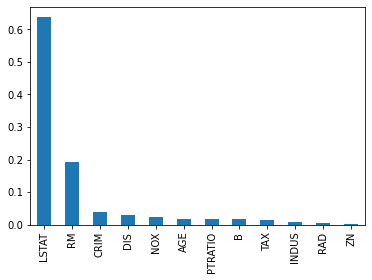

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
def rfc_feature_selection(dataset,target):
    rfc = RandomForestRegressor(random_state=42)
    rfc.fit(x, y)
    
    feature_list = list(x.columns)
    feature_imp = pd.Series(rfc.feature_importances_, index=feature_list).sort_values(ascending=False)
    print(feature_imp)
    feature_imp.plot(kind='bar')
    plt.show()

rfc_feature_selection(x,y)

* Observation:<br>
We can see that the Important features are sorted in ascending order, along with their importance in the form of bar graph.
We can clearly observe that LSTAT, RM, DIS and CRIM are the most important features that can be used for prediction.
This means that we can ignore the other columns for the House price prediction

In [13]:
x= x[['CRIM','DIS','RM','LSTAT']]
x.head(2)

,CRIM,DIS,RM,LSTAT
0,0.02763,4.0900,6.575,4.98
1,0.02763,4.9671,6.421,9.14


#### Feature Scaling

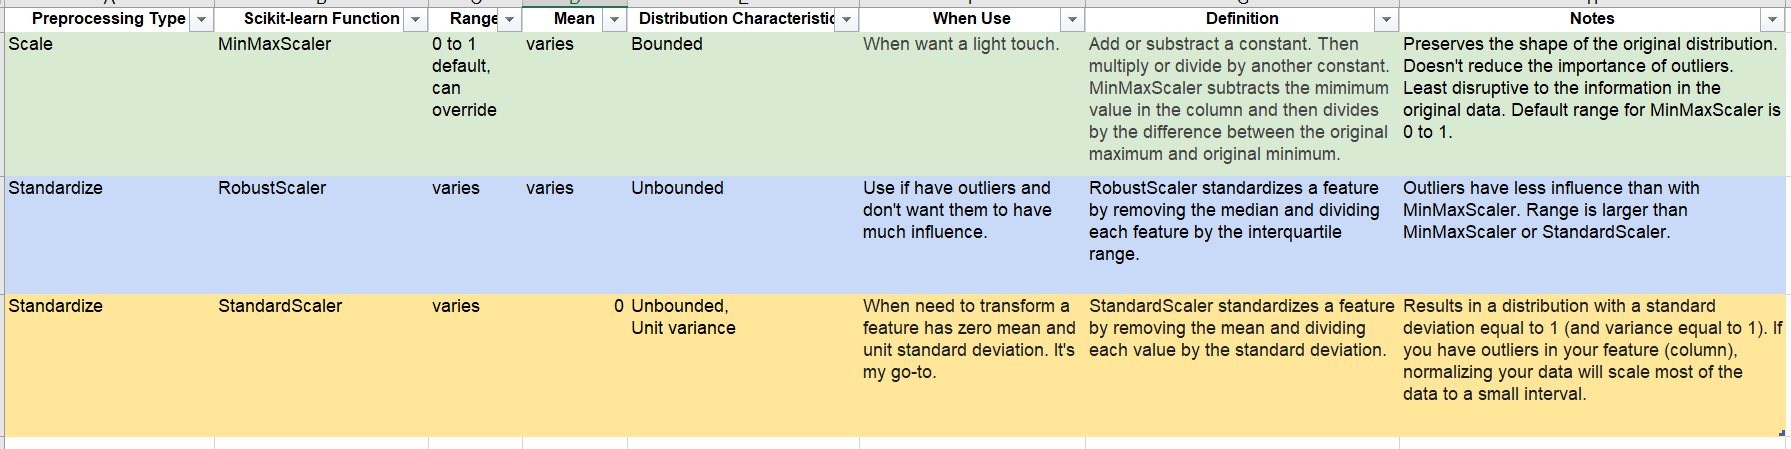

In summary, Min-Max Scaler is good to use when the data does not contain outliers, Standard Scaler is good when the data is normally distributed, and Robust Scaler is good when the data contains outliers.

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

Note that MinMaxScaler doesn’t reduce the importance of outliers.

The default range for the feature returned by MinMaxScaler is 0 to 1.

In [14]:
from sklearn.preprocessing import MinMaxScaler
mms= MinMaxScaler()
x = pd.DataFrame(mms.fit_transform(x), columns=x.columns)

x.head()

,CRIM,DIS,RM,LSTAT
0,0.000000,0.490733,0.686656,0.066013
1,0.000000,0.654441,0.603458,0.280557
2,0.000000,0.654441,1.000000,0.017019
3,0.000439,0.858839,0.915181,0.000000
4,0.003833,0.858839,0.995678,0.084064


Note: Scaling the target variable is not typically done in machine learning because the target variable represents the value that we are trying to predict. Scaling the target variable would change the interpretation of the predictions and make it difficult to compare them to the true values.

If we are trying to predict the price of a house, we would not want to scale the price of the house because it would change the interpretation of the predictions. A prediction of 0.5, for example, would not have any meaning if the target variable had been scaled.

Additionally, most of the machine learning algorithms are based on the assumption that the target variable is in its original scale, and scaling it could have an impact on the model performance. Scaling the input variables instead allows the model to learn the relationship between the inputs and the target variable in the original scale.

In some cases, it may be appropriate to scale the target variable, but it is not a common practice in machine learning and should be done with caution and a clear understanding of the impact it will have on the model and its predictions

## Splitting Data Set

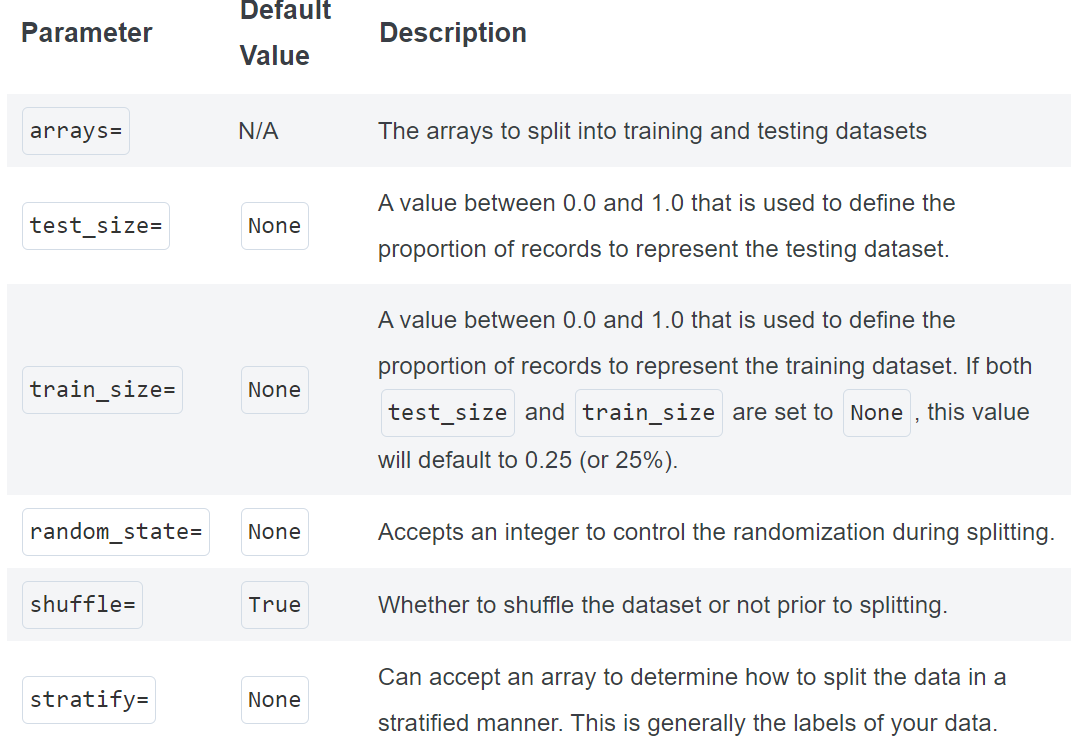

In [15]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=42)

In [16]:
print(x_train.shape)

(404, 4)


In [17]:
print(x_test.shape)

(102, 4)


### Machine Learning Modelling

#### Neural Network Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

* We are using Keras for developing the neural network.
* Models in Keras are defined as a sequence of layers
* We create a Sequential model and add layers one at a time with activation function
* Activation function decides, whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.The activation we are using is relu
* Elements of neural network has input layer, hidden layer and output layer
* input layer:- This layer accepts input features. It provides information from the outside world to the network, no computation is performed at this layer, nodes here just pass on the information(features) to the hidden layer.
* Hidden layer:-  Nodes of this layer are not exposed to the outer world, they are the part of the abstraction provided by any neural network. Hidden layer performs all sort of computation on the features entered through the input layer and transfer the result to the output layer.
* Output layer:- This layer bring up the information learned by the network to the outer world.
* Model Compilation:- The compilation is the final step in creating a model. Once the compilation is done, we can move on to training phase.
* Optimizer : - The optimizer we are using is adam. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
* Loss - mean square error

Dense layer: <br>
A dense layer, also known as a fully connected layer, is a common type of layer used in neural networks implemented in Python. These layers are called dense because they are densely connected, meaning that each neuron in the layer is connected to every neuron in the previous layer.

Dense layers are typically used in the middle or towards the end of a neural network, after some initial processing has been done by layers such as convolutional layers or pooling layers. They are used to learn a non-linear function of the input, and to make final predictions.

Dense layers can be useful for price prediction because they can learn a complex, non-linear function of the input features. In the case of price prediction, input features may include data such as historical prices, economic indicators, and other relevant market data. A dense layer can learn a non-linear function of these inputs that can accurately predict the price of a given item.

Additionally, dense layers can be used to make predictions based on the learned function. In the case of price prediction, the dense layer can output the predicted price of an item.


Activation Function used in hidden layer: <br>
The rectified linear activation function (RELU) is a piecewise linear function that, if the input is positive say x, the output will be x. otherwise, it outputs zero. ReLU (Rectified Linear Unit) is a popular activation function that is often used in the hidden layers of a neural network. There are several reasons why ReLU is a commonly used activation function in the hidden layers:

* Non-linearity: ReLU is a non-linear function, which allows the neural network to learn more complex and powerful representations of the data.

* Faster convergence: ReLU has a linear gradient, which means that the gradient descent algorithm can converge faster, as compared to other activation functions such as sigmoid or tanh.

* Reduced chance of vanishing gradient: Sigmoid and tanh activation functions can cause the gradients to become very small during backpropagation, leading to the vanishing gradient problem. ReLU activation helps to prevent this by cutting off negative values and maintaining the gradient.

* Sparsity: ReLU activation encourages the activation of a subset of neurons, making the learning process more sparse, which can improve the generalization of the model and reduces overfitting.

* Simplicity: ReLU activation is computationally efficient and easy to implement compared to other activation functions.

In conclusion, ReLU is a commonly used activation function in the hidden layers of a neural network because it allows the network to learn more complex and powerful representations of the data, converges faster, helps to prevent the vanishing gradient problem, encourages sparsity, and is computationally efficient and easy to implement.

Activation Function used in output layer: Linear <br> 

In a price prediction task, the output of the model is a continuous value, such as a dollar amount. To obtain such a continuous output, a linear activation function is often used in the output layer of the neural network.

A linear activation function simply applies a linear transformation to the input, which means that the output is directly proportional to the input. This is desirable in price prediction because the output, the predicted price, should be a direct function of the input, which is the market data used to make the prediction.

Additionally, using a linear activation function in the output layer allows the model to predict prices outside of a pre-defined range, unlike an activation function such as sigmoid or softmax which bounds the output to a specific range.

It is also worth noting that linear activation can be used in other type of prediction task as well, where the output is continuous value, and the model should be able to predict any value within a certain rang

Optimizers: 
* Optimizers update the model in response to the loss function
* They assist in minimizing loss function

Adam Optimizer (Adapative moment estimation)

Reason for using adam optimizer:
* Computationally effecient
* little memory requirements
* well suited for problems large in dataset/ parameters
* appropriate for problems with noisy/ sparse gradients
* Hyper parameters have intutive interpretation and require litlle or no tuning


Loss Function:
Quantifies the error between output and target value. MSE is used as the problem is to predict price.  
Mean Squared Error (MSE) is a commonly used loss function for predicting prices in neural networks because:

* Scale invariance: In the case of price prediction, the prices can vary widely depending on the item or service being considered. MSE is scale-invariant, meaning it does not depend on the scale of the target variable, this allows the model to work with a wide range of prices without the need to normalize or scale the data.

* Punishes large errors: When predicting prices, large errors can have a significant impact on the business, such as lost revenue or lost customers. MSE punishes large errors more than small errors, which can help to ensure that the model is not making large errors in its predictions.

* Continuity: MSE is a continuous function, this ensures that small changes in the parameters of the model will result in small changes in the loss, which makes it easier for optimization algorithms to converge to the global minimum.

* Interpreting the results: MSE is a scalar value, which makes it easy to interpret and compare the performance of different models. A lower MSE value indicates that the model is making better predictions.


In [19]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(x_train, y_train, x_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15]
    epoch_list  =   [25, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            model.add(Dense(units=32, input_dim=4, activation='relu'))

            model.add(Dense(units=16, activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, activation='linear'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(x_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial)
            y_pred_new = model.predict(x_test)
            r2_new = r2_score(y_test, y_pred_new)
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', r2_new)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(x_train, y_train, x_test, y_test)

Epoch 1/25
81/81 [==============================] - 2s 3ms/step - loss: 500.2860
Epoch 2/25
81/81 [==============================] - 0s 4ms/step - loss: 335.2314
Epoch 3/25
81/81 [==============================] - 0s 4ms/step - loss: 104.1087
Epoch 4/25
81/81 [==============================] - 0s 4ms/step - loss: 48.3472
Epoch 5/25
81/81 [==============================] - 0s 4ms/step - loss: 38.5080
Epoch 6/25
81/81 [==============================] - 0s 3ms/step - loss: 32.8409
Epoch 7/25
81/81 [==============================] - 0s 4ms/step - loss: 29.1316
Epoch 8/25
81/81 [==============================] - 0s 4ms/step - loss: 26.0848
Epoch 9/25
81/81 [==============================] - 0s 4ms/step - loss: 23.4756
Epoch 10/25
81/81 [==============================] - 0s 4ms/step - loss: 21.1816
Epoch 11/25
81/81 [==============================] - 0s 3ms/step - loss: 19.5281
Epoch 12/25
81/81 [==============================] - 0s 4ms/step - loss: 17.9890
Epoch 13/25
81/81 [===============

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


81/81 [==============================] - 2s 3ms/step - loss: 522.1577
Epoch 2/50
81/81 [==============================] - 0s 4ms/step - loss: 429.4705
Epoch 3/50
81/81 [==============================] - 0s 4ms/step - loss: 207.6119
Epoch 4/50
81/81 [==============================] - 0s 3ms/step - loss: 61.5005
Epoch 5/50
81/81 [==============================] - 0s 4ms/step - loss: 42.5513
Epoch 6/50
81/81 [==============================] - 0s 4ms/step - loss: 35.5630
Epoch 7/50
81/81 [==============================] - 0s 4ms/step - loss: 30.7607
Epoch 8/50
81/81 [==============================] - 0s 3ms/step - loss: 27.1142
Epoch 9/50
81/81 [==============================] - 0s 4ms/step - loss: 24.3903
Epoch 10/50
81/81 [==============================] - 0s 4ms/step - loss: 22.0683
Epoch 11/50
81/81 [==============================] - 0s 4ms/step - loss: 20.2181
Epoch 12/50
81/81 [==============================] - 0s 3ms/step - loss: 18.7082
Epoch 13/50
81/81 [==========================

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


Epoch 1/100
81/81 [==============================] - 3s 4ms/step - loss: 512.9482
Epoch 2/100
81/81 [==============================] - 0s 3ms/step - loss: 354.9706
Epoch 3/100
81/81 [==============================] - 0s 4ms/step - loss: 103.1744
Epoch 4/100
81/81 [==============================] - 0s 3ms/step - loss: 47.8500
Epoch 5/100
81/81 [==============================] - 0s 4ms/step - loss: 36.5535
Epoch 6/100
81/81 [==============================] - 0s 4ms/step - loss: 30.4310
Epoch 7/100
81/81 [==============================] - 0s 4ms/step - loss: 26.4696
Epoch 8/100
81/81 [==============================] - 0s 4ms/step - loss: 23.8316
Epoch 9/100
81/81 [==============================] - 0s 4ms/step - loss: 21.5569
Epoch 10/100
81/81 [==============================] - 0s 4ms/step - loss: 19.7223
Epoch 11/100
81/81 [==============================] - 0s 4ms/step - loss: 18.3070
Epoch 12/100
81/81 [==============================] - 0s 4ms/step - loss: 17.2151
Epoch 13/100
81/81 [==

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


41/41 [==============================] - 2s 4ms/step - loss: 522.2017
Epoch 2/25
41/41 [==============================] - 0s 4ms/step - loss: 477.6929
Epoch 3/25
41/41 [==============================] - 0s 3ms/step - loss: 391.2043
Epoch 4/25
41/41 [==============================] - 0s 4ms/step - loss: 248.3643
Epoch 5/25
41/41 [==============================] - 0s 4ms/step - loss: 118.3957
Epoch 6/25
41/41 [==============================] - 0s 3ms/step - loss: 67.9582
Epoch 7/25
41/41 [==============================] - 0s 3ms/step - loss: 52.9275
Epoch 8/25
41/41 [==============================] - 0s 3ms/step - loss: 44.1331
Epoch 9/25
41/41 [==============================] - 0s 4ms/step - loss: 37.7698
Epoch 10/25
41/41 [==============================] - 0s 3ms/step - loss: 32.8440
Epoch 11/25
41/41 [==============================] - 0s 3ms/step - loss: 29.3040
Epoch 12/25
41/41 [==============================] - 0s 4ms/step - loss: 26.7944
Epoch 13/25
41/41 [========================

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


Epoch 1/50
41/41 [==============================] - 2s 3ms/step - loss: 519.3904
Epoch 2/50
41/41 [==============================] - 0s 3ms/step - loss: 466.2416
Epoch 3/50
41/41 [==============================] - 0s 4ms/step - loss: 366.5520
Epoch 4/50
41/41 [==============================] - 0s 4ms/step - loss: 218.8270
Epoch 5/50
41/41 [==============================] - 0s 4ms/step - loss: 94.7053
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 51.2054
Epoch 7/50
41/41 [==============================] - 0s 4ms/step - loss: 40.9395
Epoch 8/50
41/41 [==============================] - 0s 4ms/step - loss: 35.4506
Epoch 9/50
41/41 [==============================] - 0s 4ms/step - loss: 31.9413
Epoch 10/50
41/41 [==============================] - 0s 4ms/step - loss: 29.4872
Epoch 11/50
41/41 [==============================] - 0s 4ms/step - loss: 27.6683
Epoch 12/50
41/41 [==============================] - 0s 4ms/step - loss: 26.2651
Epoch 13/50
41/41 [==============

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


41/41 [==============================] - 2s 3ms/step - loss: 528.4311
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 502.4976
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 449.7507
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 339.3945
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 181.7639
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 77.4202
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 53.6272
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 44.1848
Epoch 9/100
41/41 [==============================] - 0s 3ms/step - loss: 38.6340
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 34.4552
Epoch 11/100
41/41 [==============================] - 0s 4ms/step - loss: 31.2918
Epoch 12/100
41/41 [==============================] - 0s 3ms/step - loss: 28.9121
Epoch 13/100
41/41 [============

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


Epoch 1/25
27/27 [==============================] - 2s 3ms/step - loss: 510.4479
Epoch 2/25
27/27 [==============================] - 0s 4ms/step - loss: 471.6694
Epoch 3/25
27/27 [==============================] - 0s 4ms/step - loss: 408.6126
Epoch 4/25
27/27 [==============================] - 0s 3ms/step - loss: 316.8056
Epoch 5/25
27/27 [==============================] - 0s 3ms/step - loss: 207.9167
Epoch 6/25
27/27 [==============================] - 0s 3ms/step - loss: 115.7173
Epoch 7/25
27/27 [==============================] - 0s 4ms/step - loss: 70.9300
Epoch 8/25
27/27 [==============================] - 0s 3ms/step - loss: 57.3313
Epoch 9/25
27/27 [==============================] - 0s 4ms/step - loss: 49.0142
Epoch 10/25
27/27 [==============================] - 0s 4ms/step - loss: 43.1798
Epoch 11/25
27/27 [==============================] - 0s 3ms/step - loss: 38.7460
Epoch 12/25
27/27 [==============================] - 0s 3ms/step - loss: 35.2347
Epoch 13/25
27/27 [============

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


Epoch 1/50
27/27 [==============================] - 2s 3ms/step - loss: 525.3967
Epoch 2/50
27/27 [==============================] - 0s 3ms/step - loss: 489.8203
Epoch 3/50
27/27 [==============================] - 0s 4ms/step - loss: 434.2066
Epoch 4/50
27/27 [==============================] - 0s 3ms/step - loss: 348.9049
Epoch 5/50
27/27 [==============================] - 0s 3ms/step - loss: 240.5620
Epoch 6/50
27/27 [==============================] - 0s 4ms/step - loss: 139.6297
Epoch 7/50
27/27 [==============================] - 0s 4ms/step - loss: 82.0291
Epoch 8/50
27/27 [==============================] - 0s 3ms/step - loss: 61.5796
Epoch 9/50
27/27 [==============================] - 0s 4ms/step - loss: 51.2664
Epoch 10/50
27/27 [==============================] - 0s 4ms/step - loss: 44.7367
Epoch 11/50
27/27 [==============================] - 0s 4ms/step - loss: 39.6913
Epoch 12/50
27/27 [==============================] - 0s 4ms/step - loss: 35.9082
Epoch 13/50
27/27 [============

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


Epoch 1/100
27/27 [==============================] - 2s 2ms/step - loss: 518.7703
Epoch 2/100
27/27 [==============================] - 0s 3ms/step - loss: 484.9445
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 430.0323
Epoch 4/100
27/27 [==============================] - 0s 2ms/step - loss: 346.7764
Epoch 5/100
27/27 [==============================] - 0s 3ms/step - loss: 241.1932
Epoch 6/100
27/27 [==============================] - 0s 2ms/step - loss: 144.2487
Epoch 7/100
27/27 [==============================] - 0s 2ms/step - loss: 83.5218
Epoch 8/100
27/27 [==============================] - 0s 2ms/step - loss: 61.3303
Epoch 9/100
27/27 [==============================] - 0s 2ms/step - loss: 52.6345
Epoch 10/100
27/27 [==============================] - 0s 2ms/step - loss: 46.7348
Epoch 11/100
27/27 [==============================] - 0s 3ms/step - loss: 41.9405
Epoch 12/100
27/27 [==============================] - 0s 2ms/step - loss: 38.4195
Epoch 13/100
27/27 

C:\Users\100902467\AppData\Local\Temp\ipykernel_21896\1297861270.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), r2_new]],


In [20]:
ResultsData

,TrialNumber,Parameters,Accuracy
0,1,5-25,0.742319
0,2,5-50,0.782206
0,3,5-100,0.818265
0,4,10-25,0.687588
0,5,10-50,0.695835
0,6,10-100,0.789061
0,7,15-25,0.58449
0,8,15-50,0.691197
0,9,15-100,0.818127


<AxesSubplot:xlabel='Parameters'>

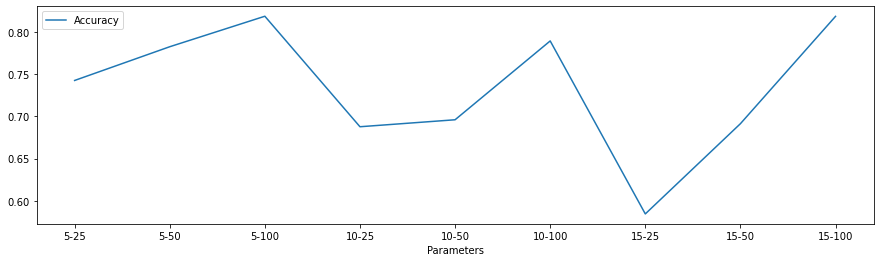

In [21]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

In [22]:
#Building Model
model = Sequential()
model.add(Dense(32, input_dim=4, activation='relu'))
model.add(Dense(16, activation='relu'))
#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
%timeit model.fit(x_train, y_train, validation_split=0.2, batch_size = 5, epochs =100)


Epoch 1/100
65/65 [==============================] - 3s 13ms/step - loss: 532.3986 - mae: 21.8959 - val_loss: 483.7583 - val_mae: 20.9842
Epoch 2/100
65/65 [==============================] - 0s 4ms/step - loss: 483.3046 - mae: 20.7102 - val_loss: 413.9774 - val_mae: 19.2247
Epoch 3/100
65/65 [==============================] - 0s 4ms/step - loss: 378.4575 - mae: 17.9236 - val_loss: 281.2972 - val_mae: 15.3137
Epoch 4/100
65/65 [==============================] - 0s 6ms/step - loss: 224.6155 - mae: 12.9925 - val_loss: 131.0664 - val_mae: 9.7850
Epoch 5/100
65/65 [==============================] - 0s 5ms/step - loss: 98.6901 - mae: 8.3740 - val_loss: 60.7198 - val_mae: 6.1724
Epoch 6/100
65/65 [==============================] - 0s 5ms/step - loss: 59.2865 - mae: 6.1556 - val_loss: 45.7702 - val_mae: 5.1605
Epoch 7/100
65/65 [==============================] - 0s 5ms/step - loss: 47.1878 - mae: 5.3772 - val_loss: 39.1890 - val_mae: 4.7367
Epoch 8/100
65/65 [==============================] - 

#### Evaluating the Neural Network Model

##### Comparing Predicted and real values

In [23]:
import numpy as np
combined_array_nn=np.column_stack((model.predict(x_test),y_test))

4/4 [==============================] - 0s 4ms/step


In [24]:
combined_array_nn

array([[24.82076263, 23.6       ],
       [31.9915905 , 32.4       ],
       [17.8510437 , 13.6       ],
       [23.52615356, 22.8       ],
       [17.04275322, 16.1       ],
       [22.3623333 , 20.        ],
       [18.67863274, 17.8       ],
       [14.60921001, 14.        ],
       [20.58448601, 19.6       ],
       [20.53654671, 16.8       ],
       [18.55672264, 21.5       ],
       [18.15402412, 18.9       ],
       [11.82146168, 10.2       ],
       [21.51790428, 21.2       ],
       [19.89135361, 18.5       ],
       [24.23818207, 29.8       ],
       [18.2350769 , 18.8       ],
       [11.76006126, 10.2       ],
       [35.21643066, 34.9       ],
       [15.03655434, 14.1       ],
       [24.63113213, 25.2       ],
       [26.16821289, 29.1       ],
       [15.9650116 , 12.7       ],
       [25.61573792, 22.4       ],
       [16.93155479, 14.2       ],
       [15.9431572 , 13.8       ],
       [21.48812103, 20.3       ],
       [14.85823727, 14.9       ],
       [19.30927658,

In [25]:
df_2 = pd.DataFrame(combined_array_nn, columns = ['predicted value','real value'])

In [26]:
df_2[10:20]

,predicted value,real value
10,18.556723,21.5
11,18.154024,18.9
12,11.821462,10.2
13,21.517904,21.2
14,19.891354,18.5
15,24.238182,29.8
16,18.235077,18.8
17,11.760061,10.2
18,35.216431,34.9
19,15.036554,14.1


In [27]:
#Evaluating Training set

mse_neural1, mae_neural1 = model.evaluate(x_train, y_train)
y_pred1 = model.predict(x_train)
r2_1 = r2_score(y_train, y_pred1)
print('Mean squared error from neural net: ', mse_neural1)
print('Mean absolute error from neural net: ', mae_neural1)
print('Accuracy score for neural net: ', r2_1)

13/13 [==============================] - 0s 4ms/step
Mean squared error from neural net:  8.907197952270508
Mean absolute error from neural net:  2.1360692977905273
Accuracy score for neural net:  0.8265152303868516


In [28]:
#Evaluating Test set
mse_neural, mae_neural = model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
print('Mean squared error from neural net: ', mse_neural)
print('Mean absolute error from neural net: ', mae_neural)
print('Accuracy score for neural net: ', r2)

4/4 [==============================] - 0s 3ms/step
Mean squared error from neural net:  7.810958385467529
Mean absolute error from neural net:  2.055210590362549
Accuracy score for neural net:  0.8161621760634898


#### Linear Regression Model

In [29]:
from sklearn import linear_model

In [30]:
### Building Model
lr_model = linear_model.LinearRegression()
%timeit lr_model.fit(x_train, y_train)

3.77 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### Comparing Predicted and real values

In [31]:
import numpy as np
combined_array_lr=np.column_stack((lr_model.predict(x_test),y_test))
combined_array_lr

array([[26.20963774, 23.6       ],
       [30.50781475, 32.4       ],
       [18.65627646, 13.6       ],
       [25.43669614, 22.8       ],
       [18.3089838 , 16.1       ],
       [22.80281769, 20.        ],
       [16.83909524, 17.8       ],
       [16.23300469, 14.        ],
       [20.94447801, 19.6       ],
       [20.94311983, 16.8       ],
       [18.01306289, 21.5       ],
       [16.61268443, 18.9       ],
       [ 8.02528509, 10.2       ],
       [21.79847958, 21.2       ],
       [19.91243097, 18.5       ],
       [25.23359197, 29.8       ],
       [18.43662533, 18.8       ],
       [ 8.06545304, 10.2       ],
       [31.39464725, 34.9       ],
       [15.58074018, 14.1       ],
       [25.98430846, 25.2       ],
       [26.87789245, 29.1       ],
       [12.60722216, 12.7       ],
       [26.69728029, 22.4       ],
       [17.55515628, 14.2       ],
       [12.56432473, 13.8       ],
       [22.63854351, 20.3       ],
       [17.43415005, 14.9       ],
       [17.885703  ,

In [32]:
df_3 = pd.DataFrame(combined_array_lr, columns = ['predicted value','real value'])
df_3[10:20]

,predicted value,real value
10,18.013063,21.5
11,16.612684,18.9
12,8.025285,10.2
13,21.798480,21.2
14,19.912431,18.5
15,25.233592,29.8
16,18.436625,18.8
17,8.065453,10.2
18,31.394647,34.9
19,15.580740,14.1


In [33]:
#Evaluation of the traing set
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred_lr1 = lr_model.predict(x_train)
mse_lr1 = mean_squared_error(y_train, y_pred_lr1)
mae_lr1 = mean_absolute_error(y_train, y_pred_lr1)
r2_lr1 = r2_score(y_train, y_pred_lr1)
print('Mean squared error from linear regression: ', mse_lr1)
print('Mean absolute error from linear regression: ', mae_lr1)
print('Model accuracy for linear regression: ', r2_lr1)

Mean squared error from linear regression:  12.525910446232047
Mean absolute error from linear regression:  2.790765406558843
Model accuracy for linear regression:  0.756033827767427


In [34]:
#Evaluation of the test set
y_pred_lr2 = lr_model.predict(x_test)
mse_lr2 = mean_squared_error(y_test, y_pred_lr2)
mae_lr2 = mean_absolute_error(y_test, y_pred_lr2)
r2_lr2 = r2_score(y_test, y_pred_lr2)
print('Mean squared error from linear regression: ', mse_lr2)
print('Mean absolute error from linear regression: ', mae_lr2)
print('Model accuracy for linear regression: ', r2_lr2)

Mean squared error from linear regression:  12.254732709613283
Mean absolute error from linear regression:  2.7703245195567305
Model accuracy for linear regression:  0.7115739765489515


#### Random Forest Model

In a Python implementation of a random forest, the number of estimators is a hyperparameter that controls the number of decision trees in the forest. A decision tree is a type of machine learning model that is used to make predictions based on input data. In a random forest, multiple decision trees are trained on different subsets of the data and their predictions are combined to make a final prediction.

Increasing the number of estimators in a random forest will increase the overall performance of the model but it will also increase the training time. The number of estimators is a trade-off between model performance and computational cost. Typically, a larger number of estimators will lead to a more accurate model, but at the cost of increased computation time.

The default value for the number of estimators in the RandomForestRegressor and RandomForestClassifier classes from scikit-learn library is 100. However, the optimal number of estimators for a given problem can vary widely depending on the size and complexity of the data

In [35]:
## Building the model
from sklearn.ensemble import RandomForestRegressor
arr = [10, 15,20,30]
for i in arr:
    model_rf = RandomForestRegressor(n_estimators = i, random_state=4)
    %timeit model_rf.fit(x_train, y_train)
    #Evalating the model
    y_pred_RF1 = model_rf.predict(x_test)
    mse_RF1 = mean_squared_error(y_test, y_pred_RF1)
    mae_RF1 = mean_absolute_error(y_test, y_pred_RF1)
    r2_RF1 = r2_score(y_test, y_pred_RF1)
    print("Summary for Random forest model with", i, "estimators")
    print("Mean squared error using Random Forest with", i, "estimators", mse_RF1)
    print("Mean absolute error Using Random Forest: with", i, "estimators", mae_RF1)
    print("Model accuracy for Random Forest: with", i, "estimators", r2_RF1)

63 ms ± 7.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 10 estimators
Mean squared error using Random Forest with 10 estimators 7.043885125544665
Mean absolute error Using Random Forest: with 10 estimators 1.9332500000000004
Model accuracy for Random Forest: with 10 estimators 0.8342159046183759
45.5 ms ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 15 estimators
Mean squared error using Random Forest with 15 estimators 7.068833361588531
Mean absolute error Using Random Forest: with 15 estimators 1.9530395787944808
Model accuracy for Random Forest: with 15 estimators 0.8336287257149466
88.3 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 20 estimators
Mean squared error using Random Forest with 20 estimators 6.983762190457819
Mean absolute error Using Random Forest: with 20 estimators 1.9193385076252725
Model accuracy for Random F

In [36]:
from sklearn.ensemble import RandomForestRegressor
arr = [10, 15,20,30]
for i in arr:
    model_rf1 = RandomForestRegressor(n_estimators = i, random_state=4)
    %timeit model_rf1.fit(x_train, y_train)
    #Evalating the model
    y_pred_RF2 = model_rf1.predict(x_train)
    mse_RF2 = mean_squared_error(y_train, y_pred_RF2)
    mae_RF2 = mean_absolute_error(y_train, y_pred_RF2)
    r2_RF2 = r2_score(y_train, y_pred_RF2)
    print("Summary for Random forest model with", i, "estimators")
    print("Mean squared error using Random Forest with", i, "estimators", mse_RF1)
    print("Mean absolute error Using Random Forest: with", i, "estimators", mae_RF1)
    print("Model accuracy for Random Forest: with", i, "estimators", r2_RF1)

45.9 ms ± 541 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 10 estimators
Mean squared error using Random Forest with 10 estimators 7.169033800939377
Mean absolute error Using Random Forest: with 10 estimators 1.904450072621642
Model accuracy for Random Forest: with 10 estimators 0.8312704193401905
67.5 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 15 estimators
Mean squared error using Random Forest with 15 estimators 7.169033800939377
Mean absolute error Using Random Forest: with 15 estimators 1.904450072621642
Model accuracy for Random Forest: with 15 estimators 0.8312704193401905
70 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Summary for Random forest model with 20 estimators
Mean squared error using Random Forest with 20 estimators 7.169033800939377
Mean absolute error Using Random Forest: with 20 estimators 1.904450072621642
Model accuracy for Random Forest: 

There is large difference in accuracy level of training and testing set and therefore it can be said that Random forest is causing overfitting. 
Accuracy on the test set being higher than on the training set in a random forest is likely due to overfitting. Random forests are built by creating multiple decision trees and allowing them to vote on the final output. Overfitting occurs when a model performs well on the training data but poorly on new, unseen data. This can happen when the model is too complex and has learned the noise in the training data instead of the underlying pattern. To combat overfitting, techniques such as pruning and setting the maximum depth of the decision trees can be used

##### Comparing Predicted and real values

In [37]:
import numpy as np
combined_array_rf = np.column_stack((model_rf.predict(x_test),y_test))
combined_array_rf

array([[24.31666667, 23.6       ],
       [31.62333333, 32.4       ],
       [17.86333333, 13.6       ],
       [22.86333333, 22.8       ],
       [15.91      , 16.1       ],
       [21.78666667, 20.        ],
       [20.56666667, 17.8       ],
       [15.81333333, 14.        ],
       [21.85333333, 19.6       ],
       [20.02333333, 16.8       ],
       [21.13      , 21.5       ],
       [19.77333333, 18.9       ],
       [10.41722222, 10.2       ],
       [21.54      , 21.2       ],
       [18.44      , 18.5       ],
       [25.48      , 29.8       ],
       [18.72333333, 18.8       ],
       [10.42722222, 10.2       ],
       [34.9       , 34.9       ],
       [15.07333333, 14.1       ],
       [23.65      , 25.2       ],
       [23.90333333, 29.1       ],
       [14.79666667, 12.7       ],
       [25.71666667, 22.4       ],
       [14.39333333, 14.2       ],
       [14.56666667, 13.8       ],
       [20.55666667, 20.3       ],
       [15.90333333, 14.9       ],
       [20.94      ,

In [38]:
df_4 = pd.DataFrame(combined_array_rf, columns = ['predicted value','real value'])
df_4[10:20]

,predicted value,real value
10,21.130000,21.5
11,19.773333,18.9
12,10.417222,10.2
13,21.540000,21.2
14,18.440000,18.5
15,25.480000,29.8
16,18.723333,18.8
17,10.427222,10.2
18,34.900000,34.9
19,15.073333,14.1


## Summary

In [39]:
prediction_columns = ["NAME OF MODEL", "ACCURACY SCORE"]
df_pred = {"NAME OF MODEL" : ["NEURAL NETWORK (Training Set)", "NEURAL NETWORK (Test Set)", "LINEAR REGRESSION (Training Set)","LINEAR REGRESSION (Test Set)", "RANDOM FOREST (Training Set)", "RANDOM FOREST (Test Set)"],
           "ACCURACY SCORE " : [r2_1, r2, r2_lr1, r2_lr2, r2_RF1, r2_RF2]}
df_predictions = pd.DataFrame (df_pred)
df_predictions

,NAME OF MODEL,ACCURACY SCORE
0,NEURAL NETWORK (Training Set),0.826515
1,NEURAL NETWORK (Test Set),0.816162
2,LINEAR REGRESSION (Training Set),0.756034
3,LINEAR REGRESSION (Test Set),0.711574
4,RANDOM FOREST (Training Set),0.831270
5,RANDOM FOREST (Test Set),0.971714


Although Random forest has highest accuracy but it is causing overfitting and therefore Neural Network should be used